In [11]:
import pandas as pd

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# all

In [2]:
q = '''select
            date_trunc('month', date) as month,
            count(id) as all_trans,
            count(case when recurring=0 then id else null end) as onetime_trans,
            count(case when recurring_origin=1 then id else null end) as recurring_trans
        from transactions
        where status='A' 
        group by date_trunc('month', date)'''
trans = redshift_query_read(q, schema='production')

In [4]:
trans['all_origin'] = trans['onetime_trans'] + trans['recurring_trans']

In [3]:
q = '''select
            date_trunc('month', date) as month,
            sum(views) as page_views
        from googleanalytics_traffic
        group by date_trunc('month', date)'''
traff = redshift_query_read(q, schema='production')

In [5]:
df = trans.merge(traff, on='month')
df['conversion_all'] = df['all_trans'] / df['page_views']
df['conversion_origin'] = df['all_origin'] / df['page_views']
df['conversion_onetime'] = df['onetime_trans'] / df['page_views']
df['conversion_rec'] = df['recurring_trans'] / df['page_views']

In [28]:
df.sort_values('month')[['month'] + [c for c in df.columns if 'conv' in c]].tail(6)

,month,conversion_all,conversion_origin,conversion_onetime,conversion_rec
78,2023-01-01,0.077457,0.038593,0.037061,0.001531
4,2023-02-01,0.061679,0.035059,0.034055,0.001004
66,2023-03-01,0.066593,0.039564,0.037912,0.001652
47,2023-04-01,0.086226,0.043378,0.041204,0.002174
48,2023-05-01,0.076126,0.043611,0.042181,0.001430
51,2023-06-01,0.097133,0.047421,0.045575,0.001846


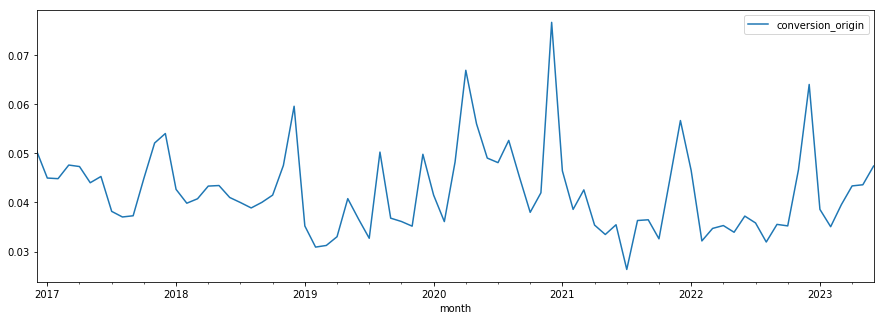

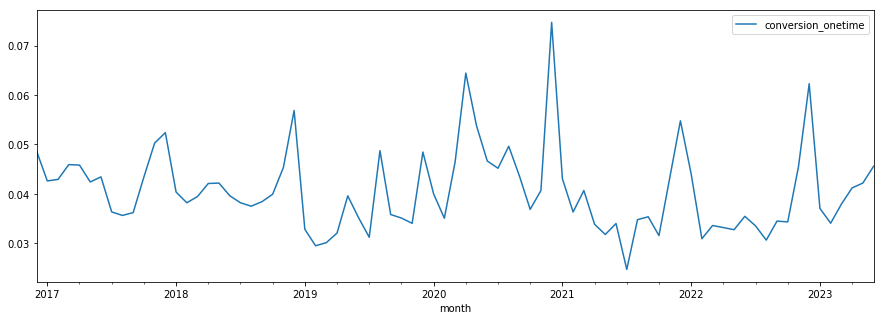

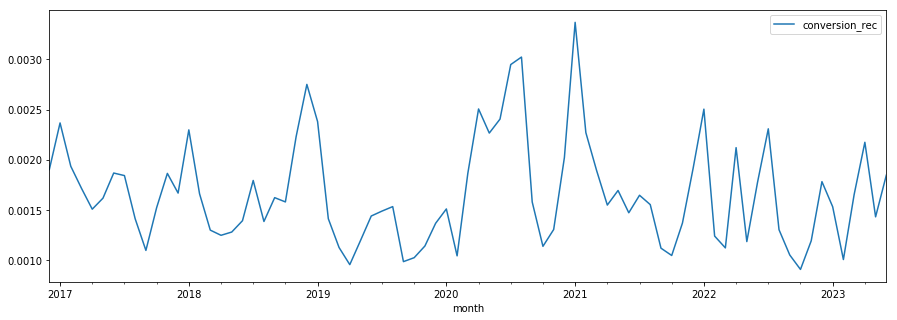

In [16]:
df.sort_values('month')[['month', 'conversion_origin']].plot(x='month', figsize=(15,5))
df.sort_values('month')[['month', 'conversion_onetime']].plot(x='month', figsize=(15,5))
df.sort_values('month')[['month', 'conversion_rec']].plot(x='month', figsize=(15,5))

In [17]:
df[['conversion_origin', 'conversion_onetime', 'conversion_rec']].agg(['median', 'mean'])

,conversion_origin,conversion_onetime,conversion_rec
median,0.040784,0.039590,0.001552
mean,0.042251,0.040587,0.001664


# grouped by form

In [18]:
q = '''select
            date_trunc('month', date) as month,
            form,
            count(id) as all_trans,
            count(case when recurring=0 then id else null end) as onetime_trans,
            count(case when recurring_origin=1 then id else null end) as recurring_trans
        from transactions
        where status='A' 
        group by date_trunc('month', date), form'''
trans_forms = redshift_query_read(q, schema='production')

In [19]:
trans_forms['all_origin'] = trans_forms['onetime_trans'] + trans_forms['recurring_trans']

In [20]:
q = '''select
            form,
            date_trunc('month', date) as month,
            sum(views) as page_views
        from googleanalytics_traffic
        group by date_trunc('month', date), form'''
traff_forms = redshift_query_read(q, schema='production')

In [21]:
df_forms = trans_forms.merge(traff_forms, on=['month', 'form'])
df_forms['conversion_all'] = df_forms['all_trans'] / df_forms['page_views']
df_forms['conversion_origin'] = df_forms['all_origin'] / df_forms['page_views']
df_forms['conversion_onetime'] = df_forms['onetime_trans'] / df_forms['page_views']
df_forms['conversion_rec'] = df_forms['recurring_trans'] / df_forms['page_views']

In [22]:
df_forms[['conversion_origin', 'conversion_onetime', 'conversion_rec']].agg(['median', 'mean'])

,conversion_origin,conversion_onetime,conversion_rec
median,0.068182,0.060109,0.0
mean,inf,inf,inf


In [27]:
df_forms[df_forms['conversion_origin']<1.][['conversion_origin', 'conversion_onetime', 'conversion_rec']].agg(['median', 'mean'])

,conversion_origin,conversion_onetime,conversion_rec
median,0.055556,0.048544,0.000000
mean,0.118512,0.109830,0.008682


# conditional fields

In [32]:
q = '''select
            date_trunc('month', date) as month,
            form,
            avg(conditional_fields) as conditional_fields
        from public.analyticsqgiv_weekly
        where date>='2023-01-01' and conditional_fields>0
        group by date_trunc('month', date), form;'''
cond = redshift_query_read(q, schema='production')

In [33]:
len(cond), len(cond['form'].unique())

(4460, 1226)

In [35]:
grps = cond.groupby('form')['conditional_fields'].agg(['min', 'max'])
len(grps), len(grps[grps['min']!=grps['max']])

(1226, 17)

## w/ conditional fields

In [36]:
q = '''select
            date_trunc('month', t.date) as month,
            count(case when recurring=0 then t.id else null end) as trans_onetime,
            count(case when recurring_origin=1 then t.id else null end) as trans_recurring
        from production.transactions as t
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and conditional_fields>0
                    group by date_trunc('month', date), form) as cond_fields
                on date_trunc('month', t.date)=cond_fields.month and t.form=cond_fields.form
        where
            t.status='A'
        group by date_trunc('month', t.date)'''
cond_trans = redshift_query_read(q, schema='production')

In [37]:
q = '''select
            date_trunc('month', ga.date) as month,
            sum(ga.views) as page_views
        from production.googleanalytics_traffic as ga
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and conditional_fields>0
                    group by date_trunc('month', date), form) as cond_fields
                on date_trunc('month', ga.date)=cond_fields.month and ga.form=cond_fields.form
        group by date_trunc('month', ga.date)'''
cond_traffic = redshift_query_read(q, schema='production')

In [38]:
cond = cond_trans.merge(cond_traffic, on='month')
cond['conversion'] = (cond['trans_onetime'] + cond['trans_recurring']) / cond['page_views']
cond['conversion_onetime'] = cond['trans_onetime'] / cond['page_views']
cond['conversion_recurring'] = cond['trans_recurring'] / cond['page_views']

In [40]:
cond[cond['conversion']<1.][['conversion', 'conversion_onetime', 'conversion_recurring']].agg(['mean', 'median'])

,conversion,conversion_onetime,conversion_recurring
mean,0.103100,0.097227,0.005873
median,0.099785,0.094295,0.005491


In [43]:
cond[['month'] + [c for c in cond.columns if 'conv' in c]].sort_values('month')

,month,conversion,conversion_onetime,conversion_recurring
3,2023-02-01,0.081068,0.077166,0.003902
2,2023-03-01,0.085757,0.081392,0.004365
0,2023-04-01,0.113814,0.107197,0.006616
1,2023-05-01,0.131759,0.123153,0.008606


## w/out conditional fields

In [44]:
q = '''select
            date_trunc('month', t.date) as month,
            count(case when recurring=0 then t.id else null end) as trans_onetime,
            count(case when recurring_origin=1 then t.id else null end) as trans_recurring
        from production.transactions as t
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and conditional_fields=0
                    group by date_trunc('month', date), form) as cond_fields
                on date_trunc('month', t.date)=cond_fields.month and t.form=cond_fields.form
        where
            t.status='A'
        group by date_trunc('month', t.date)'''
cond_trans = redshift_query_read(q, schema='production')

In [45]:
q = '''select
            date_trunc('month', ga.date) as month,
            sum(ga.views) as page_views
        from production.googleanalytics_traffic as ga
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and conditional_fields=0
                    group by date_trunc('month', date), form) as cond_fields
                on date_trunc('month', ga.date)=cond_fields.month and ga.form=cond_fields.form
        group by date_trunc('month', ga.date)'''
cond_traffic = redshift_query_read(q, schema='production')

In [46]:
cond = cond_trans.merge(cond_traffic, on='month')
cond['conversion'] = (cond['trans_onetime'] + cond['trans_recurring']) / cond['page_views']
cond['conversion_onetime'] = cond['trans_onetime'] / cond['page_views']
cond['conversion_recurring'] = cond['trans_recurring'] / cond['page_views']

In [47]:
cond[cond['conversion']<1.][['conversion', 'conversion_onetime', 'conversion_recurring']].agg(['mean', 'median'])

,conversion,conversion_onetime,conversion_recurring
mean,0.091015,0.085343,0.005672
median,0.093038,0.087688,0.005350


In [48]:
cond[['month'] + [c for c in cond.columns if 'conv' in c]].sort_values('month')

,month,conversion,conversion_onetime,conversion_recurring
2,2023-02-01,0.075546,0.071683,0.003863
3,2023-03-01,0.089709,0.083552,0.006157
0,2023-04-01,0.102437,0.094313,0.008123
1,2023-05-01,0.096367,0.091823,0.004544


# multistep vs single step

## multistep

In [49]:
q = '''select
            date_trunc('month', t.date) as month,
            count(case when recurring=0 then t.id else null end) as trans_onetime,
            count(case when recurring_origin=1 then t.id else null end) as trans_recurring
        from production.transactions as t
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and appearance=2
                    group by date_trunc('month', date), form) as multistep
                on date_trunc('month', t.date)=multistep.month and t.form=multistep.form
        where
            t.status='A'
        group by date_trunc('month', t.date)'''
multistep_trans = redshift_query_read(q, schema='production')

In [50]:
q = '''select
            date_trunc('month', ga.date) as month,
            sum(ga.views) as page_views
        from production.googleanalytics_traffic as ga
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and appearance=2
                    group by date_trunc('month', date), form) as multistep
                on date_trunc('month', ga.date)=multistep.month and ga.form=multistep.form
        group by date_trunc('month', ga.date)'''
multistep_traffic = redshift_query_read(q, schema='production')

In [51]:
multistep = multistep_trans.merge(multistep_traffic, on='month')
multistep['conversion'] = (multistep['trans_onetime'] + multistep['trans_recurring']) / multistep['page_views']
multistep['conversion_onetime'] = multistep['trans_onetime'] / multistep['page_views']
multistep['conversion_recurring'] = multistep['trans_recurring'] / multistep['page_views']

In [52]:
multistep[multistep['conversion']<1.][['conversion', 'conversion_onetime', 'conversion_recurring']].agg(['mean', 'median'])

,conversion,conversion_onetime,conversion_recurring
mean,0.094041,0.087562,0.006480
median,0.096426,0.088170,0.005847


In [53]:
multistep[['month'] + [c for c in multistep.columns if 'conv' in c]].sort_values('month')

,month,conversion,conversion_onetime,conversion_recurring
0,2023-02-01,0.083602,0.079010,0.004592
3,2023-03-01,0.094969,0.088092,0.006878
1,2023-04-01,0.097882,0.088249,0.009633
2,2023-05-01,0.099712,0.094895,0.004817


## single step

In [54]:
q = '''select
            date_trunc('month', t.date) as month,
            count(case when recurring=0 then t.id else null end) as trans_onetime,
            count(case when recurring_origin=1 then t.id else null end) as trans_recurring
        from production.transactions as t
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and appearance!=2
                    group by date_trunc('month', date), form) as multistep
                on date_trunc('month', t.date)=multistep.month and t.form=multistep.form
        where
            t.status='A'
        group by date_trunc('month', t.date)'''
singlestep_trans = redshift_query_read(q, schema='production')

In [55]:
q = '''select
            date_trunc('month', ga.date) as month,
            sum(ga.views) as page_views
        from production.googleanalytics_traffic as ga
            join (select
                        date_trunc('month', date) as month,
                        form
                    from public.analyticsqgiv_weekly
                    where date>='2023-01-01' and appearance!=2
                    group by date_trunc('month', date), form) as multistep
                on date_trunc('month', ga.date)=multistep.month and ga.form=multistep.form
        group by date_trunc('month', ga.date)'''
singlestep_traffic = redshift_query_read(q, schema='production')

In [56]:
singlestep = singlestep_trans.merge(singlestep_traffic, on='month')
singlestep['conversion'] = (singlestep['trans_onetime'] + singlestep['trans_recurring']) / singlestep['page_views']
singlestep['conversion_onetime'] = singlestep['trans_onetime'] / singlestep['page_views']
singlestep['conversion_recurring'] = singlestep['trans_recurring'] / singlestep['page_views']

In [57]:
singlestep[singlestep['conversion']<1.][['conversion', 'conversion_onetime', 'conversion_recurring']].agg(['mean', 'median'])

,conversion,conversion_onetime,conversion_recurring
mean,0.088450,0.084312,0.004138
median,0.086389,0.082223,0.004166


In [58]:
singlestep[['month'] + [c for c in singlestep.columns if 'conv' in c]].sort_values('month')

,month,conversion,conversion_onetime,conversion_recurring
1,2023-02-01,0.068993,0.065475,0.003518
0,2023-03-01,0.080171,0.076191,0.003980
2,2023-04-01,0.112030,0.107329,0.004701
3,2023-05-01,0.092606,0.088255,0.004351
